## 기초 탐색 및 데이터 준비

#### 학습 데이터 불러오기

In [35]:
import pandas as pd
import os

os.chdir(r"/Users/sanghyuk/Documents/preprocessing_python/lecture_source/6.-실전-머신러닝-프로젝트/6. 실전 머신러닝 프로젝트/23. 상점 신용카드 매출 예측/데이터")

In [36]:
# df의 시간 범위: 2016-06-01 ~ 2019-02-28
df = pd.read_csv("funda_train.csv")
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [37]:
df.tail()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
6556608,2136,4663855,d,2019-02-28,23:20,0,제주 제주시,기타 주점업,-4500.000000
6556609,2136,4663855,d,2019-02-28,23:24,0,제주 제주시,기타 주점업,4142.857143
6556610,2136,4663489,a,2019-02-28,23:24,0,제주 제주시,기타 주점업,4500.000000
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,기타 주점업,571.428571
6556612,2136,4658616,c,2019-02-28,23:54,0,제주 제주시,기타 주점업,5857.142857


In [38]:
# submission_df의 범위: 2019-03-01 ~ 2019-05-31
submission_df = pd.read_csv("submission.csv")
submission_df.head()

,store_id,amount
0,0,0
1,1,0
2,2,0
3,4,0
4,5,0


#### 변수 목록 탐색

In [39]:
# 상점 ID는 일치
print(df['store_id'].unique())
print(submission_df['store_id'].unique())

[   0    1    2 ... 2134 2135 2136]
[   0    1    2 ... 2134 2135 2136]


In [40]:
print(df.columns)
print(submission_df.columns)

# 일치하는 컬럼이 store_id와 amount 밖에 없으므로, 새로운 특징을 추출하는 것이 바람직함

Index(['store_id', 'card_id', 'card_company', 'transacted_date',
       'transacted_time', 'installment_term', 'region', 'type_of_business',
       'amount'],
      dtype='object')
Index(['store_id', 'amount'], dtype='object')


- 예측 대상은 3개월 합계이고, 가지고 있는 데이터는 분단위로 정리되어 있음
- t-2, t-1, t월의 데이터로 t + 1, t + 2, t + 3월의 매출 합계를 예측하는 것으로 문제를 정의
- 따라서 거래 내역을 요약하여 월별로 데이터를 새로 정의하는 것이 중요

## 학습 데이터 구축

#### 년/월 추출

In [41]:
# .str.split을 이용한 년/월 추출
df['transacted_year'] = df['transacted_date'].str.split('-', expand = True).iloc[:, 0].astype(int)
df['transacted_month'] = df['transacted_date'].str.split('-', expand = True).iloc[:, 1].astype(int)
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,transacted_year,transacted_month
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016,6
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016,6
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016,6
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016,6
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016,6


In [42]:
# 데이터 병합을 위한 새로운 컬럼 생성 및 기존 시간 변수 삭제
df['t'] = (df['transacted_year'] - 2016) * 12 + df['transacted_month']
df.drop(['transacted_year', 'transacted_month', 'transacted_date', 'transacted_time'], axis = 1, inplace = True)
df.head()

,store_id,card_id,card_company,installment_term,region,type_of_business,amount,t
0,0,0,b,0,NaN,기타 미용업,1857.142857,6
1,0,1,h,0,NaN,기타 미용업,857.142857,6
2,0,2,c,0,NaN,기타 미용업,2000.000000,6
3,0,3,a,0,NaN,기타 미용업,7857.142857,6
4,0,4,c,0,NaN,기타 미용업,2000.000000,6


#### 불필요한 변수 제거
- card_id, card_company는 특징으로 사용하기에는 너무 세분화될 수 있을 뿐만 아니라, 특징으로 유효할 가능성이 없다고 판단하여 삭제

In [43]:
df.head()

,store_id,card_id,card_company,installment_term,region,type_of_business,amount,t
0,0,0,b,0,NaN,기타 미용업,1857.142857,6
1,0,1,h,0,NaN,기타 미용업,857.142857,6
2,0,2,c,0,NaN,기타 미용업,2000.000000,6
3,0,3,a,0,NaN,기타 미용업,7857.142857,6
4,0,4,c,0,NaN,기타 미용업,2000.000000,6


In [44]:
df.drop(['card_id', 'card_company'], axis = 1, inplace = True)

#### 업종 특성, 지역, 할부 평균 탐색

In [45]:
df['installment_term'].value_counts().head() # 대부분이 일시불이므로, installment_term 변수를 할부인지 아닌지를 여부로 변환

0    6327632
3     134709
2      42101
5      23751
6      10792
Name: installment_term, dtype: int64

In [46]:
df['installment_term'] = (df['installment_term'] > 0).astype(int)
df['installment_term'].value_counts()

0    6327632
1     228981
Name: installment_term, dtype: int64

In [47]:
df.columns

Index(['store_id', 'installment_term', 'region', 'type_of_business', 'amount',
       't'],
      dtype='object')

In [48]:
df.groupby(['store_id'])["installment_term"].mean()

store_id
0       0.038384
1       0.000000
2       0.083904
4       0.001201
5       0.075077
          ...   
2132    0.001389
2133    0.014916
2134    0.002261
2135    0.001554
2136    0.001226
Name: installment_term, Length: 1967, dtype: float64

In [49]:
# 상점별 평균 할부 비율
installment_term_per_store = df.groupby(['store_id'])['installment_term'].mean()
installment_term_per_store.head()

store_id
0    0.038384
1    0.000000
2    0.083904
4    0.001201
5    0.075077
Name: installment_term, dtype: float64

In [50]:
# groupby에 결측을 포함시키기 위해, 결측을 문자로 대체
# 지역은 너무 많아서 그대로 활용하기 어려움. 따라서 그대로 더미화하지 않고, 이를 기반으로 한 새로운 변수를 파생해서 사용
df['region'].fillna('없음', inplace = True)
df['region'].value_counts().head()

없음        2042766
경기 수원시     122029
충북 청주시     116766
경남 창원시     107147
경남 김해시     100673
Name: region, dtype: int64

In [51]:
len(df['region'].value_counts())

181

In [52]:
df.head()

,store_id,installment_term,region,type_of_business,amount,t
0,0,0,없음,기타 미용업,1857.142857,6
1,0,0,없음,기타 미용업,857.142857,6
2,0,0,없음,기타 미용업,2000.000000,6
3,0,0,없음,기타 미용업,7857.142857,6
4,0,0,없음,기타 미용업,2000.000000,6


In [53]:
df['type_of_business'].value_counts().head()
# 업종도 그 수가 너무 많아 그대로 활용하기 어려움

한식 음식점업    745905
두발 미용업     178475
의복 소매업     158234
기타 주점업     102413
치킨 전문점      89277
Name: type_of_business, dtype: int64

In [68]:
sum(df['type_of_business'].isna())/len(df['type_of_business'].isna())

0.6028431142725672

In [69]:
# groupby에 결측을 포함시키기 위해, 결측을 문자로 대체
df['type_of_business'].fillna('없음', inplace = True)

#### 학습 데이터 구조 작성

In [70]:
df.head(10)

,store_id,installment_term,region,type_of_business,amount,t
0,0,0,없음,기타 미용업,1857.142857,6
1,0,0,없음,기타 미용업,857.142857,6
2,0,0,없음,기타 미용업,2000.000000,6
3,0,0,없음,기타 미용업,7857.142857,6
4,0,0,없음,기타 미용업,2000.000000,6
5,0,0,없음,기타 미용업,2000.000000,6
6,0,0,없음,기타 미용업,2000.000000,6
7,0,0,없음,기타 미용업,7857.142857,6
8,0,0,없음,기타 미용업,2000.000000,6
9,0,0,없음,기타 미용업,1857.142857,6


In [71]:
df.drop_duplicates(subset = ['store_id', 'region', 'type_of_business', 't'])

,store_id,installment_term,region,type_of_business,amount,t
0,0,0,없음,기타 미용업,1857.142857,6
145,0,0,없음,기타 미용업,2142.857143,7
323,0,0,없음,기타 미용업,2000.000000,8
494,0,0,없음,기타 미용업,2000.000000,9
654,0,0,없음,기타 미용업,2000.000000,10
...,...,...,...,...,...,...
6554843,2136,0,제주 제주시,기타 주점업,4428.571429,34
6555181,2136,0,제주 제주시,기타 주점업,3857.142857,35
6555537,2136,0,제주 제주시,기타 주점업,8285.714286,36
6555940,2136,0,제주 제주시,기타 주점업,4571.428571,37


In [134]:
# 'store_id', 'region', 'type_of_business', 't'를 기준으로 중복을 제거한 뒤, 해당 컬럼만 가져옴
train_df = df.drop_duplicates(subset = ['store_id', 'region', 'type_of_business', 't'])[['store_id', 'region', 'type_of_business', 't']]
train_df.head()

,store_id,region,type_of_business,t
0,0,없음,기타 미용업,6
145,0,없음,기타 미용업,7
323,0,없음,기타 미용업,8
494,0,없음,기타 미용업,9
654,0,없음,기타 미용업,10


#### 평균 할부율 부착

In [135]:
installment_term_per_store

store_id
0       0.038384
1       0.000000
2       0.083904
4       0.001201
5       0.075077
          ...   
2132    0.001389
2133    0.014916
2134    0.002261
2135    0.001554
2136    0.001226
Name: installment_term, Length: 1967, dtype: float64

In [136]:
train_df['store_id'].replace(installment_term_per_store.to_dict())

0          0.038384
145        0.038384
323        0.038384
494        0.038384
654        0.038384
             ...   
6554843    0.001226
6555181    0.001226
6555537    0.001226
6555940    0.001226
6556237    0.001226
Name: store_id, Length: 60232, dtype: float64

In [137]:
train_df['평균할부율'] = train_df['store_id'].replace(installment_term_per_store.to_dict())

In [138]:
train_df.head()

,store_id,region,type_of_business,t,평균할부율
0,0,없음,기타 미용업,6,0.038384
145,0,없음,기타 미용업,7,0.038384
323,0,없음,기타 미용업,8,0.038384
494,0,없음,기타 미용업,9,0.038384
654,0,없음,기타 미용업,10,0.038384


#### t-1, t-2, t-3 시점의 매출 합계 부착

In [139]:
# store_id와 t에 따른 amount 합계 계산: amount_sum_per_t_and_sid
amount_sum_per_t_and_sid = df.groupby(['store_id', 't'], as_index = False)['amount'].sum()
amount_sum_per_t_and_sid.head()

,store_id,t,amount
0,0,6,7.470000e+05
1,0,7,1.005000e+06
2,0,8,8.715714e+05
3,0,9,8.978571e+05
4,0,10,8.354286e+05


In [140]:
# 몇몇 상점은 중간이 비어있음을 확인 => merge에서 문제가 생길 수 있음
amount_sum_per_t_and_sid.groupby(['store_id'])['t'].count().head(10)

store_id
0     33
1     33
2     33
4     33
5     33
6     31
7     31
8     28
9     29
10    23
Name: t, dtype: int64

In [141]:
# 따라서 모든 값을 채우기 위해, 피벗 테이블을 생성하고 결측을 바로 앞 값으로 채움
amount_sum_per_t_and_sid = pd.pivot_table(df, values = 'amount', index = 'store_id', columns = 't', aggfunc = 'sum')
amount_sum_per_t_and_sid.head(10)

t,6,7,8,9,10,11,12,13,14,15,...,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,
0,747000.000000,1.005000e+06,871571.428571,8.978571e+05,8.354286e+05,6.970000e+05,7.618571e+05,585642.857143,7.940000e+05,720257.142857,...,6.864286e+05,7.072857e+05,7.587143e+05,6.798571e+05,6.518571e+05,7.390000e+05,6.760000e+05,8.745714e+05,6.828571e+05,5.152857e+05
1,137214.285714,1.630000e+05,118142.857143,9.042857e+04,1.180714e+05,1.118571e+05,1.155714e+05,129642.857143,1.602143e+05,168428.571429,...,8.050000e+04,7.828571e+04,1.007857e+05,9.214286e+04,6.357143e+04,9.500000e+04,8.078571e+04,8.528571e+04,1.482857e+05,7.742857e+04
2,260714.285714,8.285714e+04,131428.571429,1.428571e+05,1.097143e+05,1.985714e+05,1.600000e+05,180714.285714,1.542857e+05,43571.428571,...,4.728571e+05,3.542857e+05,6.892857e+05,4.578571e+05,4.807143e+05,5.100000e+05,1.854286e+05,3.407143e+05,4.078571e+05,4.968571e+05
4,733428.571429,7.689286e+05,698428.571429,9.364286e+05,7.627143e+05,8.595714e+05,1.069857e+06,689142.857143,1.050143e+06,970285.714286,...,7.754286e+05,8.812857e+05,1.050929e+06,8.492857e+05,6.981429e+05,8.284286e+05,8.830000e+05,9.238571e+05,9.448571e+05,8.822857e+05
5,342500.000000,4.327143e+05,263500.000000,2.321429e+05,2.115714e+05,1.820857e+05,1.475714e+05,120957.142857,1.864286e+05,169000.000000,...,4.438571e+05,5.637143e+05,6.070714e+05,4.828857e+05,1.950000e+05,3.249286e+05,3.833000e+05,3.995714e+05,3.230000e+05,2.155143e+05
6,NaN,NaN,568857.142857,1.440143e+06,1.238857e+06,1.055429e+06,9.268571e+05,885642.857143,8.003571e+05,930714.285714,...,1.808357e+06,1.752286e+06,1.583786e+06,1.628786e+06,2.074071e+06,1.907643e+06,2.389143e+06,2.230286e+06,2.015500e+06,2.463857e+06
7,NaN,NaN,107857.142857,3.756429e+05,3.236429e+05,3.450000e+05,2.914286e+05,231614.285714,2.713571e+05,249857.142857,...,2.657143e+05,4.195429e+05,4.628429e+05,4.231286e+05,3.203286e+05,4.200286e+05,3.143857e+05,3.024143e+05,1.364714e+05,5.797143e+04
8,NaN,NaN,NaN,NaN,NaN,1.925714e+05,7.355000e+05,467857.142857,4.756429e+05,603500.000000,...,1.837429e+06,1.359857e+06,1.213543e+06,1.086000e+06,1.369557e+06,1.272071e+06,1.260557e+06,1.157257e+06,1.134671e+06,1.298329e+06
9,NaN,NaN,NaN,NaN,1.071429e+05,6.371429e+05,6.035714e+05,225428.571429,2.871429e+05,344428.571429,...,6.385714e+05,2.765714e+05,3.400000e+05,2.542857e+05,9.265714e+05,8.714286e+05,6.928571e+05,6.628571e+05,3.700000e+05,4.057143e+05


In [142]:
amount_sum_per_t_and_sid.fillna(method = 'bfill', axis = 1).head(10)

t,6,7,8,9,10,11,12,13,14,15,...,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,
0,747000.000000,1.005000e+06,871571.428571,8.978571e+05,8.354286e+05,6.970000e+05,7.618571e+05,585642.857143,7.940000e+05,720257.142857,...,6.864286e+05,7.072857e+05,7.587143e+05,6.798571e+05,6.518571e+05,7.390000e+05,6.760000e+05,8.745714e+05,6.828571e+05,5.152857e+05
1,137214.285714,1.630000e+05,118142.857143,9.042857e+04,1.180714e+05,1.118571e+05,1.155714e+05,129642.857143,1.602143e+05,168428.571429,...,8.050000e+04,7.828571e+04,1.007857e+05,9.214286e+04,6.357143e+04,9.500000e+04,8.078571e+04,8.528571e+04,1.482857e+05,7.742857e+04
2,260714.285714,8.285714e+04,131428.571429,1.428571e+05,1.097143e+05,1.985714e+05,1.600000e+05,180714.285714,1.542857e+05,43571.428571,...,4.728571e+05,3.542857e+05,6.892857e+05,4.578571e+05,4.807143e+05,5.100000e+05,1.854286e+05,3.407143e+05,4.078571e+05,4.968571e+05
4,733428.571429,7.689286e+05,698428.571429,9.364286e+05,7.627143e+05,8.595714e+05,1.069857e+06,689142.857143,1.050143e+06,970285.714286,...,7.754286e+05,8.812857e+05,1.050929e+06,8.492857e+05,6.981429e+05,8.284286e+05,8.830000e+05,9.238571e+05,9.448571e+05,8.822857e+05
5,342500.000000,4.327143e+05,263500.000000,2.321429e+05,2.115714e+05,1.820857e+05,1.475714e+05,120957.142857,1.864286e+05,169000.000000,...,4.438571e+05,5.637143e+05,6.070714e+05,4.828857e+05,1.950000e+05,3.249286e+05,3.833000e+05,3.995714e+05,3.230000e+05,2.155143e+05
6,568857.142857,5.688571e+05,568857.142857,1.440143e+06,1.238857e+06,1.055429e+06,9.268571e+05,885642.857143,8.003571e+05,930714.285714,...,1.808357e+06,1.752286e+06,1.583786e+06,1.628786e+06,2.074071e+06,1.907643e+06,2.389143e+06,2.230286e+06,2.015500e+06,2.463857e+06
7,107857.142857,1.078571e+05,107857.142857,3.756429e+05,3.236429e+05,3.450000e+05,2.914286e+05,231614.285714,2.713571e+05,249857.142857,...,2.657143e+05,4.195429e+05,4.628429e+05,4.231286e+05,3.203286e+05,4.200286e+05,3.143857e+05,3.024143e+05,1.364714e+05,5.797143e+04
8,192571.428571,1.925714e+05,192571.428571,1.925714e+05,1.925714e+05,1.925714e+05,7.355000e+05,467857.142857,4.756429e+05,603500.000000,...,1.837429e+06,1.359857e+06,1.213543e+06,1.086000e+06,1.369557e+06,1.272071e+06,1.260557e+06,1.157257e+06,1.134671e+06,1.298329e+06
9,107142.857143,1.071429e+05,107142.857143,1.071429e+05,1.071429e+05,6.371429e+05,6.035714e+05,225428.571429,2.871429e+05,344428.571429,...,6.385714e+05,2.765714e+05,3.400000e+05,2.542857e+05,9.265714e+05,8.714286e+05,6.928571e+05,6.628571e+05,3.700000e+05,4.057143e+05


In [143]:
# 따라서 모든 값을 채우기 위해, 피벗 테이블을 생성하고 결측을 바로 앞 값으로 채움
# ffill : 뒤 방향으로 결측값 채우기
# bfill : 앞 방향으로 결측값 채우기

amount_sum_per_t_and_sid = amount_sum_per_t_and_sid.fillna(method = 'ffill', axis = 1).fillna(method = 'bfill', axis = 1)
amount_sum_per_t_and_sid.head(10)

t,6,7,8,9,10,11,12,13,14,15,...,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,
0,747000.000000,1.005000e+06,871571.428571,8.978571e+05,8.354286e+05,6.970000e+05,7.618571e+05,585642.857143,7.940000e+05,720257.142857,...,6.864286e+05,7.072857e+05,7.587143e+05,6.798571e+05,6.518571e+05,7.390000e+05,6.760000e+05,8.745714e+05,6.828571e+05,5.152857e+05
1,137214.285714,1.630000e+05,118142.857143,9.042857e+04,1.180714e+05,1.118571e+05,1.155714e+05,129642.857143,1.602143e+05,168428.571429,...,8.050000e+04,7.828571e+04,1.007857e+05,9.214286e+04,6.357143e+04,9.500000e+04,8.078571e+04,8.528571e+04,1.482857e+05,7.742857e+04
2,260714.285714,8.285714e+04,131428.571429,1.428571e+05,1.097143e+05,1.985714e+05,1.600000e+05,180714.285714,1.542857e+05,43571.428571,...,4.728571e+05,3.542857e+05,6.892857e+05,4.578571e+05,4.807143e+05,5.100000e+05,1.854286e+05,3.407143e+05,4.078571e+05,4.968571e+05
4,733428.571429,7.689286e+05,698428.571429,9.364286e+05,7.627143e+05,8.595714e+05,1.069857e+06,689142.857143,1.050143e+06,970285.714286,...,7.754286e+05,8.812857e+05,1.050929e+06,8.492857e+05,6.981429e+05,8.284286e+05,8.830000e+05,9.238571e+05,9.448571e+05,8.822857e+05
5,342500.000000,4.327143e+05,263500.000000,2.321429e+05,2.115714e+05,1.820857e+05,1.475714e+05,120957.142857,1.864286e+05,169000.000000,...,4.438571e+05,5.637143e+05,6.070714e+05,4.828857e+05,1.950000e+05,3.249286e+05,3.833000e+05,3.995714e+05,3.230000e+05,2.155143e+05
6,568857.142857,5.688571e+05,568857.142857,1.440143e+06,1.238857e+06,1.055429e+06,9.268571e+05,885642.857143,8.003571e+05,930714.285714,...,1.808357e+06,1.752286e+06,1.583786e+06,1.628786e+06,2.074071e+06,1.907643e+06,2.389143e+06,2.230286e+06,2.015500e+06,2.463857e+06
7,107857.142857,1.078571e+05,107857.142857,3.756429e+05,3.236429e+05,3.450000e+05,2.914286e+05,231614.285714,2.713571e+05,249857.142857,...,2.657143e+05,4.195429e+05,4.628429e+05,4.231286e+05,3.203286e+05,4.200286e+05,3.143857e+05,3.024143e+05,1.364714e+05,5.797143e+04
8,192571.428571,1.925714e+05,192571.428571,1.925714e+05,1.925714e+05,1.925714e+05,7.355000e+05,467857.142857,4.756429e+05,603500.000000,...,1.837429e+06,1.359857e+06,1.213543e+06,1.086000e+06,1.369557e+06,1.272071e+06,1.260557e+06,1.157257e+06,1.134671e+06,1.298329e+06
9,107142.857143,1.071429e+05,107142.857143,1.071429e+05,1.071429e+05,6.371429e+05,6.035714e+05,225428.571429,2.871429e+05,344428.571429,...,6.385714e+05,2.765714e+05,3.400000e+05,2.542857e+05,9.265714e+05,8.714286e+05,6.928571e+05,6.628571e+05,3.700000e+05,4.057143e+05


In [144]:
amount_sum_per_t_and_sid.stack().reset_index()

,store_id,t,0
0,0,6,7.470000e+05
1,0,7,1.005000e+06
2,0,8,8.715714e+05
3,0,9,8.978571e+05
4,0,10,8.354286e+05
...,...,...,...
64906,2136,34,2.012214e+06
64907,2136,35,2.135429e+06
64908,2136,36,2.427429e+06
64909,2136,37,1.873643e+06


In [145]:
# stack을 이용하여, 컬럼도 행 인덱스로 밀어넣고, 인덱스를 초기화하여 인덱스를 컬럼으로 가져옴
amount_sum_per_t_and_sid = amount_sum_per_t_and_sid.stack().reset_index()
amount_sum_per_t_and_sid.rename({0:"amount"}, axis = 1, inplace = True)

In [146]:
amount_sum_per_t_and_sid

,store_id,t,amount
0,0,6,7.470000e+05
1,0,7,1.005000e+06
2,0,8,8.715714e+05
3,0,9,8.978571e+05
4,0,10,8.354286e+05
...,...,...,...
64906,2136,34,2.012214e+06
64907,2136,35,2.135429e+06
64908,2136,36,2.427429e+06
64909,2136,37,1.873643e+06


In [147]:
amount_sum_per_t_and_sid['t'] + 1

0         7
1         8
2         9
3        10
4        11
         ..
64906    35
64907    36
64908    37
64909    38
64910    39
Name: t, Length: 64911, dtype: int64

In [148]:
demo_amount = amount_sum_per_t_and_sid

In [149]:
demo_amount["t_1"] = amount_sum_per_t_and_sid['t'] + 1
demo_amount

,store_id,t,amount,t_1
0,0,6,7.470000e+05,7
1,0,7,1.005000e+06,8
2,0,8,8.715714e+05,9
3,0,9,8.978571e+05,10
4,0,10,8.354286e+05,11
...,...,...,...,...
64906,2136,34,2.012214e+06,35
64907,2136,35,2.135429e+06,36
64908,2136,36,2.427429e+06,37
64909,2136,37,1.873643e+06,38


In [150]:
train_df.head()

,store_id,region,type_of_business,t,평균할부율
0,0,없음,기타 미용업,6,0.038384
145,0,없음,기타 미용업,7,0.038384
323,0,없음,기타 미용업,8,0.038384
494,0,없음,기타 미용업,9,0.038384
654,0,없음,기타 미용업,10,0.038384


In [151]:
# t - k (k = 1, 2, 3) 시점의 부착
# train_df의 t는 amount_sum_per_t_and_sid의 t-k과 부착되어야 하므로, amount_sum_per_t_and_sid의 t에 k를 더함

for k in range(1, 4):
    amount_sum_per_t_and_sid['t_{}'.format(k)] = amount_sum_per_t_and_sid['t'] + k
    train_df = pd.merge(train_df, amount_sum_per_t_and_sid.drop('t', axis = 1), left_on = ['store_id', 't'], right_on = ['store_id', 't_{}'.format(k)])
    
    # 부착한 뒤, 불필요한 변수 제거 및 변수명 변경: 다음 이터레이션에서의 병합이 잘되게 하기 위해서
    train_df.rename({"amount":"{}_before_amount".format(k)}, axis = 1, inplace = True)
    train_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_sum_per_t_and_sid.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    
train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,7.470000e+05
1,0,없음,기타 미용업,10,0.038384,897857.142857,8.715714e+05,1.005000e+06
2,0,없음,기타 미용업,11,0.038384,835428.571429,8.978571e+05,8.715714e+05
3,0,없음,기타 미용업,12,0.038384,697000.000000,8.354286e+05,8.978571e+05
4,0,없음,기타 미용업,13,0.038384,761857.142857,6.970000e+05,8.354286e+05


#### t-1, t-2, t-3 시점의 지역별 매출 합계 평균 부착

In [116]:
df.head()

,store_id,installment_term,region,type_of_business,amount,t
0,0,0,없음,기타 미용업,1857.142857,6
1,0,0,없음,기타 미용업,857.142857,6
2,0,0,없음,기타 미용업,2000.000000,6
3,0,0,없음,기타 미용업,7857.142857,6
4,0,0,없음,기타 미용업,2000.000000,6


In [114]:
df[['store_id', 'region']].drop_duplicates().set_index(['store_id'])['region'].to_dict()

{0: '없음',
 1: '없음',
 2: '없음',
 4: '서울 종로구',
 5: '없음',
 6: '충북 충주시',
 7: '없음',
 8: '부산 동래구',
 9: '경기 평택시',
 10: '없음',
 11: '부산 동구',
 12: '서울 종로구',
 13: '없음',
 14: '없음',
 15: '광주 동구',
 16: '경기 파주시',
 17: '대구 수성구',
 18: '없음',
 19: '경기 용인시',
 20: '서울 중구',
 22: '없음',
 23: '경기 안양시',
 24: '없음',
 25: '경기 수원시',
 26: '없음',
 27: '서울 중구',
 28: '경기 화성시',
 29: '없음',
 30: '경기 안양시',
 31: '서울 송파구',
 32: '서울 마포구',
 33: '서울 마포구',
 34: '서울 마포구',
 35: '서울 마포구',
 36: '서울 마포구',
 37: '서울 마포구',
 38: '서울 마포구',
 40: '서울 마포구',
 41: '서울 마포구',
 42: '없음',
 43: '서울 마포구',
 45: '부산 부산진구',
 46: '서울 마포구',
 47: '서울 용산구',
 48: '충남 금산군',
 49: '서울 중랑구',
 50: '서울 용산구',
 51: '서울 용산구',
 52: '전남 목포시',
 53: '경기 안성시',
 54: '없음',
 55: '없음',
 57: '서울 영등포구',
 58: '서울 동작구',
 59: '서울 동작구',
 60: '없음',
 61: '없음',
 62: '서울 동작구',
 64: '경기 과천시',
 66: '경북 경주시',
 67: '인천 계양구',
 68: '없음',
 69: '서울 강서구',
 70: '서울 강서구',
 71: '없음',
 72: '경기 성남시',
 73: '서울 강서구',
 74: '서울 강서구',
 75: '인천 남동구',
 76: '없음',
 77: '서울 광진구',
 78: '없음',
 79: '없음',
 80: '서울

In [152]:
amount_sum_per_t_and_sid.head()

,store_id,t,amount
0,0,6,7.470000e+05
1,0,7,1.005000e+06
2,0,8,8.715714e+05
3,0,9,8.978571e+05
4,0,10,8.354286e+05


In [153]:
# amount_sum_per_t_and_sid의 store_id를 region으로 대체시키기
store_to_region = df[['store_id', 'region']].drop_duplicates().set_index(['store_id'])['region'].to_dict()
amount_sum_per_t_and_sid['region'] = amount_sum_per_t_and_sid['store_id'].replace(store_to_region)
amount_sum_per_t_and_sid.head()

,store_id,t,amount,region
0,0,6,7.470000e+05,없음
1,0,7,1.005000e+06,없음
2,0,8,8.715714e+05,없음
3,0,9,8.978571e+05,없음
4,0,10,8.354286e+05,없음


In [154]:
# 지역별 평균 매출 계산
amount_mean_per_t_and_region = amount_sum_per_t_and_sid.groupby(['region', 't'], as_index = False)['amount'].mean()
amount_mean_per_t_and_region

,region,t,amount
0,강원 강릉시,6,6.232717e+05
1,강원 강릉시,7,5.013114e+05
2,강원 강릉시,8,5.081308e+05
3,강원 강릉시,9,6.592378e+05
4,강원 강릉시,10,7.768940e+05
...,...,...,...
5968,충북 충주시,34,1.302804e+06
5969,충북 충주시,35,1.149001e+06
5970,충북 충주시,36,1.201487e+06
5971,충북 충주시,37,1.024702e+06


In [155]:
train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,7.470000e+05
1,0,없음,기타 미용업,10,0.038384,897857.142857,8.715714e+05,1.005000e+06
2,0,없음,기타 미용업,11,0.038384,835428.571429,8.978571e+05,8.715714e+05
3,0,없음,기타 미용업,12,0.038384,697000.000000,8.354286e+05,8.978571e+05
4,0,없음,기타 미용업,13,0.038384,761857.142857,6.970000e+05,8.354286e+05


In [156]:
# t - k (k = 1, 2, 3) 시점의 부착

for k in range(1, 4):
    amount_mean_per_t_and_region['t_{}'.format(k)] = amount_mean_per_t_and_region['t'] + k
    train_df = pd.merge(train_df, amount_mean_per_t_and_region.drop('t', axis = 1), left_on = ['region', 't'], right_on = ['region', 't_{}'.format(k)])
    train_df.rename({"amount":"{}_before_amount_of_region".format(k)}, axis = 1, inplace = True)
    
    train_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_mean_per_t_and_region.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    
train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,761987.421532,756108.674948,739654.068323
1,1,없음,없음,9,0.000000,118142.857143,1.630000e+05,137214.285714,761987.421532,756108.674948,739654.068323
2,2,없음,없음,9,0.083904,131428.571429,8.285714e+04,260714.285714,761987.421532,756108.674948,739654.068323
3,5,없음,의복 액세서리 및 모조 장신구 도매업,9,0.075077,263500.000000,4.327143e+05,342500.000000,761987.421532,756108.674948,739654.068323
4,7,없음,없음,9,0.011558,107857.142857,1.078571e+05,107857.142857,761987.421532,756108.674948,739654.068323


#### t-1, t-2, t-3 시점의 업종별 매출 합계 평균 부착

In [157]:
amount_sum_per_t_and_sid.head()

,store_id,t,amount,region
0,0,6,7.470000e+05,없음
1,0,7,1.005000e+06,없음
2,0,8,8.715714e+05,없음
3,0,9,8.978571e+05,없음
4,0,10,8.354286e+05,없음


In [159]:
# amount_sum_per_t_and_sid의 store_id를 type_of_business으로 대체시키기
store_to_type_of_business = df[['store_id', 'type_of_business']].drop_duplicates().set_index(['store_id'])['type_of_business'].to_dict()
amount_sum_per_t_and_sid['type_of_business'] = amount_sum_per_t_and_sid['store_id'].replace(store_to_type_of_business)

# 지역별 평균 매출 계산
amount_mean_per_t_and_type_of_business = amount_sum_per_t_and_sid.groupby(['type_of_business', 't'], as_index = False)['amount'].mean()
amount_mean_per_t_and_type_of_business

,type_of_business,t,amount
0,가구 소매업,6,3.111190e+06
1,가구 소매업,7,3.572095e+06
2,가구 소매업,8,3.140524e+06
3,가구 소매업,9,2.347524e+06
4,가구 소매업,10,3.243429e+06
...,...,...,...
4813,화훼류 및 식물 도매업,34,8.712429e+05
4814,화훼류 및 식물 도매업,35,1.095900e+06
4815,화훼류 및 식물 도매업,36,1.478900e+06
4816,화훼류 및 식물 도매업,37,1.699929e+06


In [160]:
train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,761987.421532,756108.674948,739654.068323
1,1,없음,없음,9,0.000000,118142.857143,1.630000e+05,137214.285714,761987.421532,756108.674948,739654.068323
2,2,없음,없음,9,0.083904,131428.571429,8.285714e+04,260714.285714,761987.421532,756108.674948,739654.068323
3,5,없음,의복 액세서리 및 모조 장신구 도매업,9,0.075077,263500.000000,4.327143e+05,342500.000000,761987.421532,756108.674948,739654.068323
4,7,없음,없음,9,0.011558,107857.142857,1.078571e+05,107857.142857,761987.421532,756108.674948,739654.068323


In [161]:
# t - k (k = 1, 2, 3) 시점의 부착
# train_df의 t는 amount_sum_per_t_and_sid의 t-k과 부착되어야 하므로, amount_sum_per_t_and_sid의 t에 k를 더함

for k in range(1, 4):
    amount_mean_per_t_and_type_of_business['t_{}'.format(k)] = amount_mean_per_t_and_type_of_business['t'] + k
    train_df = pd.merge(train_df, amount_mean_per_t_and_type_of_business.drop('t', axis = 1), left_on = ['type_of_business', 't'], right_on = ['type_of_business', 't_{}'.format(k)])
    train_df.rename({"amount":"{}_before_amount_of_type_of_business".format(k)}, axis = 1, inplace = True)
    
    train_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_mean_per_t_and_type_of_business.drop(['t_{}'.format(k)], axis = 1, inplace = True)       
    
train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0
1,792,없음,기타 미용업,9,0.218887,681142.857143,8.808571e+05,733714.285714,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0
2,23,경기 안양시,기타 미용업,9,0.048795,879242.857143,7.308571e+05,845285.714286,8.288317e+05,5.887330e+05,9.559733e+05,761025.0,804979.761905,679950.0
3,192,경기 화성시,기타 미용업,9,0.100542,579000.000000,5.234286e+05,551142.857143,1.234460e+06,1.227921e+06,1.180455e+06,761025.0,804979.761905,679950.0
4,536,서울 광진구,기타 미용업,9,0.014810,96285.714286,7.985714e+04,99857.142857,3.786820e+06,3.397973e+06,3.524075e+06,761025.0,804979.761905,679950.0


In [163]:
train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0
1,792,없음,기타 미용업,9,0.218887,681142.857143,8.808571e+05,733714.285714,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0
2,23,경기 안양시,기타 미용업,9,0.048795,879242.857143,7.308571e+05,845285.714286,8.288317e+05,5.887330e+05,9.559733e+05,761025.0,804979.761905,679950.0
3,192,경기 화성시,기타 미용업,9,0.100542,579000.000000,5.234286e+05,551142.857143,1.234460e+06,1.227921e+06,1.180455e+06,761025.0,804979.761905,679950.0
4,536,서울 광진구,기타 미용업,9,0.014810,96285.714286,7.985714e+04,99857.142857,3.786820e+06,3.397973e+06,3.524075e+06,761025.0,804979.761905,679950.0


#### 라벨 부착하기

In [27]:
# 현 시점에서 t + 1, t + 2, t + 3의 매출을 부착해야 함

In [164]:
amount_sum_per_t_and_sid

,store_id,t,amount,region,type_of_business
0,0,6,7.470000e+05,없음,기타 미용업
1,0,7,1.005000e+06,없음,기타 미용업
2,0,8,8.715714e+05,없음,기타 미용업
3,0,9,8.978571e+05,없음,기타 미용업
4,0,10,8.354286e+05,없음,기타 미용업
...,...,...,...,...,...
64906,2136,34,2.012214e+06,제주 제주시,기타 주점업
64907,2136,35,2.135429e+06,제주 제주시,기타 주점업
64908,2136,36,2.427429e+06,제주 제주시,기타 주점업
64909,2136,37,1.873643e+06,제주 제주시,기타 주점업


In [165]:
amount_sum_per_t_and_sid.drop(['region', 'type_of_business'], axis = 1, inplace = True)
for k in range(1, 4):
    amount_sum_per_t_and_sid['t_{}'.format(k)] = amount_sum_per_t_and_sid['t'] - k   
    train_df = pd.merge(train_df, amount_sum_per_t_and_sid.drop('t', axis = 1), left_on = ['store_id', 't'], right_on = ['store_id', 't_{}'.format(k)])
    train_df.rename({"amount": "Y_{}".format(k)}, axis = 1, inplace = True)
    
    train_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_sum_per_t_and_sid.drop(['t_{}'.format(k)], axis = 1, inplace = True)      

In [166]:
train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business,Y_1,Y_2,Y_3
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0,835428.571429,697000.000000,761857.142857
1,792,없음,기타 미용업,9,0.218887,681142.857143,8.808571e+05,733714.285714,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0,725142.857143,653428.571429,730071.428571
2,23,경기 안양시,기타 미용업,9,0.048795,879242.857143,7.308571e+05,845285.714286,8.288317e+05,5.887330e+05,9.559733e+05,761025.0,804979.761905,679950.0,741714.285714,608857.142857,844285.714286
3,192,경기 화성시,기타 미용업,9,0.100542,579000.000000,5.234286e+05,551142.857143,1.234460e+06,1.227921e+06,1.180455e+06,761025.0,804979.761905,679950.0,529000.000000,545142.857143,449714.285714
4,536,서울 광진구,기타 미용업,9,0.014810,96285.714286,7.985714e+04,99857.142857,3.786820e+06,3.397973e+06,3.524075e+06,761025.0,804979.761905,679950.0,87142.857143,159928.571429,124142.857143


In [167]:
train_df['Y'] = train_df['Y_1'] + train_df['Y_2'] + train_df['Y_3']

In [168]:
train_df

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business,Y_1,Y_2,Y_3,Y
0,0,없음,기타 미용업,9,0.038384,8.715714e+05,1.005000e+06,7.470000e+05,7.619874e+05,7.561087e+05,7.396541e+05,7.610250e+05,8.049798e+05,6.799500e+05,8.354286e+05,6.970000e+05,7.618571e+05,2.294286e+06
1,792,없음,기타 미용업,9,0.218887,6.811429e+05,8.808571e+05,7.337143e+05,7.619874e+05,7.561087e+05,7.396541e+05,7.610250e+05,8.049798e+05,6.799500e+05,7.251429e+05,6.534286e+05,7.300714e+05,2.108643e+06
2,23,경기 안양시,기타 미용업,9,0.048795,8.792429e+05,7.308571e+05,8.452857e+05,8.288317e+05,5.887330e+05,9.559733e+05,7.610250e+05,8.049798e+05,6.799500e+05,7.417143e+05,6.088571e+05,8.442857e+05,2.194857e+06
3,192,경기 화성시,기타 미용업,9,0.100542,5.790000e+05,5.234286e+05,5.511429e+05,1.234460e+06,1.227921e+06,1.180455e+06,7.610250e+05,8.049798e+05,6.799500e+05,5.290000e+05,5.451429e+05,4.497143e+05,1.523857e+06
4,536,서울 광진구,기타 미용업,9,0.014810,9.628571e+04,7.985714e+04,9.985714e+04,3.786820e+06,3.397973e+06,3.524075e+06,7.610250e+05,8.049798e+05,6.799500e+05,8.714286e+04,1.599286e+05,1.241429e+05,3.712143e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50226,1601,부산 기장군,일반 병원,31,0.098576,1.248916e+07,1.101463e+07,9.346414e+06,3.512850e+06,3.562410e+06,3.732217e+06,1.248916e+07,1.101463e+07,9.346414e+06,1.362359e+07,1.082650e+07,1.205359e+07,3.650367e+07
50227,1601,부산 기장군,일반 병원,32,0.098576,1.108017e+07,1.248916e+07,1.101463e+07,3.314836e+06,3.512850e+06,3.562410e+06,1.108017e+07,1.248916e+07,1.101463e+07,1.082650e+07,1.205359e+07,1.291621e+07,3.579630e+07
50228,1601,부산 기장군,일반 병원,33,0.098576,1.362359e+07,1.108017e+07,1.248916e+07,3.808238e+06,3.314836e+06,3.512850e+06,1.362359e+07,1.108017e+07,1.248916e+07,1.205359e+07,1.291621e+07,1.329000e+07,3.825980e+07
50229,1601,부산 기장군,일반 병원,34,0.098576,1.082650e+07,1.362359e+07,1.108017e+07,3.240926e+06,3.808238e+06,3.314836e+06,1.082650e+07,1.362359e+07,1.108017e+07,1.291621e+07,1.329000e+07,1.535530e+07,4.156151e+07


## 학습 데이터 탐색 및 전처리

#### 특징과 라벨 분리

In [175]:
X = train_df.drop(['store_id', 'region', 'type_of_business', 't', 'Y_1', 'Y_2', 'Y_3', 'Y'], axis = 1)
Y = train_df['Y']

In [176]:
X.head()

,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0.038384,871571.428571,1.005000e+06,747000.000000,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0
1,0.218887,681142.857143,8.808571e+05,733714.285714,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0
2,0.048795,879242.857143,7.308571e+05,845285.714286,8.288317e+05,5.887330e+05,9.559733e+05,761025.0,804979.761905,679950.0
3,0.100542,579000.000000,5.234286e+05,551142.857143,1.234460e+06,1.227921e+06,1.180455e+06,761025.0,804979.761905,679950.0
4,0.014810,96285.714286,7.985714e+04,99857.142857,3.786820e+06,3.397973e+06,3.524075e+06,761025.0,804979.761905,679950.0


#### 데이터 분할 및 구조 탐색

In [177]:
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)
Train_X.shape # 특징 대비 샘플이 많음

(37673, 10)

In [178]:
Train_Y.describe()

count    3.767300e+04
mean     3.431889e+06
std      5.117338e+06
min     -1.747857e+05
25%      1.136300e+06
50%      2.211714e+06
75%      4.090286e+06
max      1.727659e+08
Name: Y, dtype: float64

최댓값이 매우 큼

#### 이상치 제거

In [179]:
import numpy as np
def IQR_rule(val_list): # 한 특징에 포함된 값 (열 벡터)
    # IQR 계산    
    Q1 = np.quantile(val_list, 0.25)
    Q3 = np.quantile(val_list, 0.75)
    IQR = Q3 - Q1
    
    # IQR rule을 위배하지 않는 bool list 계산 (True: 이상치 X, False: 이상치 O)
    not_outlier_condition = (Q3 + 1.5 * IQR > val_list) & (Q1 - 1.5 * IQR < val_list)
    return not_outlier_condition

In [180]:
Y_condition = IQR_rule(Train_Y)
Train_Y = Train_Y[Y_condition]
Train_X = Train_X[Y_condition]

#### 치우침 제거

In [182]:
# 모두 좌로 치우침을 확인
Train_X.skew()

평균할부율                                  3.012299
1_before_amount                        2.299924
2_before_amount                        2.426034
3_before_amount                        2.428857
1_before_amount_of_region              3.243216
2_before_amount_of_region              3.207858
3_before_amount_of_region              3.176680
1_before_amount_of_type_of_business    1.762514
2_before_amount_of_type_of_business    1.881011
3_before_amount_of_type_of_business    1.910386
dtype: float64

(array([14842.,  7823.,  4375.,  3255.,  2130.,  1128.,   553.,   599.,
          200.,    50.]),
 array([0.        , 0.0950902 , 0.19018039, 0.28527059, 0.38036079,
        0.47545099, 0.57054118, 0.66563138, 0.76072158, 0.85581177,
        0.95090197]),
 <BarContainer object of 10 artists>)

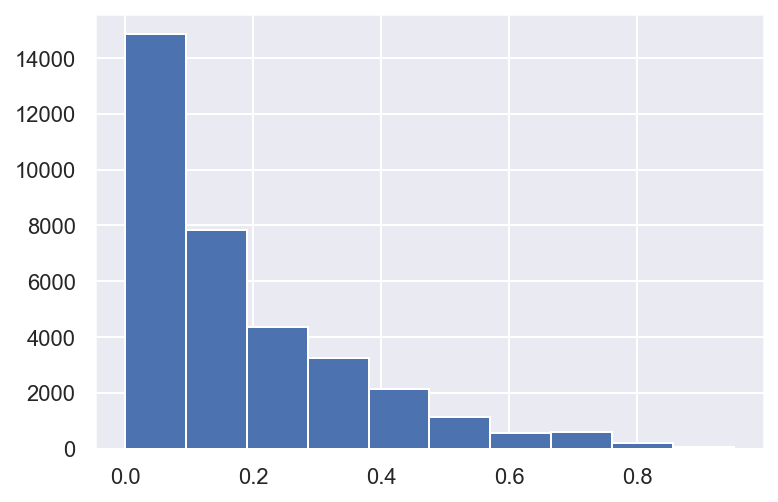

In [200]:
plt.hist(np.sqrt(Train_X["평균할부율"]-min(Train_X["평균할부율"])))

In [37]:
# 치우침 제거
import numpy as np
biased_variables = Train_X.columns[Train_X.skew().abs() > 1.5] # 왜도의 절대값이 1.5 이상인 컬럼만 가져오기
Train_X[biased_variables] = Train_X[biased_variables] - Train_X[biased_variables].min() + 1
Train_X[biased_variables] = np.sqrt(Train_X[biased_variables])

In [38]:
Train_X.skew()

평균할부율                                  2.782873
1_before_amount                        0.739012
2_before_amount                        0.731783
3_before_amount                        0.743576
1_before_amount_of_region              1.874513
2_before_amount_of_region              1.826711
3_before_amount_of_region              1.814483
1_before_amount_of_type_of_business   -0.272532
2_before_amount_of_type_of_business   -0.249009
3_before_amount_of_type_of_business   -0.257339
dtype: float64

#### 스케일링 수행

In [201]:
Train_X.max() - Train_X.min() # 특징 간 스케일 차이가 큼을 확인 => 스케일이 작은 특징은 영향을 거의 주지 못할 것이라 예상됨

평균할부율                                  9.042146e-01
1_before_amount                        1.293143e+07
2_before_amount                        1.293143e+07
3_before_amount                        1.293143e+07
1_before_amount_of_region              6.704143e+06
2_before_amount_of_region              6.704143e+06
3_before_amount_of_region              6.704143e+06
1_before_amount_of_type_of_business    6.670429e+06
2_before_amount_of_type_of_business    6.838429e+06
3_before_amount_of_type_of_business    6.838429e+06
dtype: float64

In [203]:
# 스케일링 수행
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(Train_X)
s_Train_X = scaler.transform(Train_X)
s_Test_X = scaler.transform(Test_X)

Train_X = pd.DataFrame(s_Train_X, columns = Train_X.columns)
Test_X = pd.DataFrame(s_Test_X, columns = Train_X.columns)

del s_Train_X, s_Test_X # 메모리 관리를 위해, 불필요한 값은 제거

#### 모델 학습 

샘플 대비 특징이 적고, 특징의 타입이 전부 연속형으로 같음

- 모델 1. kNN
- 모델 2. RandomForestRegressor
- 모델 3. LightGBM

- 특징 선택: 3 ~ 10개 (기준: f_regression)

In [206]:
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RFR
from lightgbm import LGBMRegressor as LGB
from sklearn.feature_selection import *

In [207]:
# 파라미터 그리드 생성
param_grid = dict() 
# 입력: 모델 함수, 출력: 모델의 하이퍼 파라미터 그리드

# 모델별 파라미터 그리드 생성
param_grid_for_knn = ParameterGrid({"n_neighbors": [1, 3, 5, 7],
                           "metric":['euclidean', 'cosine']})

param_grid_for_RFR = ParameterGrid({"max_depth": [1, 2, 3, 4],
                           "n_estimators":[100, 200],
                                   "max_samples":[0.5, 0.6, 0.7, None]}) # 특징 대비 샘플이 많아서 붓스트랩 비율 (max_samples)을 설정 

param_grid_for_LGB = ParameterGrid({"max_depth": [1, 2, 3, 4],
                                   "n_estimators":[100, 200],
                            "learning_rate": [0.05, 0.1, 0.15]})

# 모델 - 하이퍼 파라미터 그리드를 param_grid에 추가
param_grid[KNN] = param_grid_for_knn
param_grid[RFR] = param_grid_for_RFR
param_grid[LGB] = param_grid_for_LGB

In [219]:
max_iter_num = 0
for k in range(10, 2, -1):
    for M in param_grid.keys():
        for P in param_grid[M]:
            max_iter_num += 1
max_iter_num            

512

In [222]:
SelectKBest(f_regression, k=3).fit(Train_X, Train_Y).get_support()

array([False,  True,  True,  True, False, False, False, False, False,
       False])

In [223]:
# 출력을 위한 max_iter_num 계산
max_iter_num = 0
for k in range(10, 2, -1):
    for M in param_grid.keys():
        for P in param_grid[M]:
            max_iter_num += 1
           
from sklearn.metrics import mean_absolute_error as MAE

best_score = 9999999999
iteration_num = 0
for k in range(10, 2, -1): # 메모리 부담 해소를 위해, 1씩 감소시킴
    selector = SelectKBest(f_regression, k = k).fit(Train_X, Train_Y)
    selected_features = Train_X.columns[selector.get_support()]

    Train_X = Train_X[selected_features]
    Test_X = Test_X[selected_features]
    
    for M in param_grid.keys():
        for P in param_grid[M]:
            # LightGBM에서 DataFrame이 잘 처리되지 않는 것을 방지하기 위해 .values를 사용
            model = M(**P).fit(Train_X.values, Train_Y.values)
            pred_Y = model.predict(Test_X.values)
            score = MAE(Test_Y.values, pred_Y)
            
            if score < best_score:
                best_score = score
                best_model = M
                best_paramter = P
                best_features = selected_features    
                
            iteration_num += 1
            print("iter_num:{}/{}, score: {}, best_score: {}".format(iteration_num, max_iter_num, round(score, 2), round(best_score, 2)))

iter_num:1/512, score: 1399941.75, best_score: 1399941.75
iter_num:2/512, score: 1268787.68, best_score: 1268787.68
iter_num:3/512, score: 1242150.91, best_score: 1242150.91
iter_num:4/512, score: 1235201.27, best_score: 1235201.27
iter_num:5/512, score: 1580576.77, best_score: 1235201.27
iter_num:6/512, score: 1428836.95, best_score: 1235201.27
iter_num:7/512, score: 1392713.51, best_score: 1235201.27
iter_num:8/512, score: 1382576.71, best_score: 1235201.27
iter_num:9/512, score: 1661143.31, best_score: 1235201.27
iter_num:10/512, score: 1663158.85, best_score: 1235201.27
iter_num:11/512, score: 1661098.49, best_score: 1235201.27
iter_num:12/512, score: 1660310.57, best_score: 1235201.27
iter_num:13/512, score: 1661622.45, best_score: 1235201.27
iter_num:14/512, score: 1664183.71, best_score: 1235201.27
iter_num:15/512, score: 1663349.89, best_score: 1235201.27
iter_num:16/512, score: 1665689.48, best_score: 1235201.27
iter_num:17/512, score: 1367538.31, best_score: 1235201.27
iter_n

iter_num:140/512, score: 1660871.14, best_score: 1196614.55
iter_num:141/512, score: 1662634.46, best_score: 1196614.55
iter_num:142/512, score: 1664034.31, best_score: 1196614.55
iter_num:143/512, score: 1664562.35, best_score: 1196614.55
iter_num:144/512, score: 1666772.93, best_score: 1196614.55
iter_num:145/512, score: 1369333.06, best_score: 1196614.55
iter_num:146/512, score: 1371561.22, best_score: 1196614.55
iter_num:147/512, score: 1375103.64, best_score: 1196614.55
iter_num:148/512, score: 1371736.52, best_score: 1196614.55
iter_num:149/512, score: 1374181.46, best_score: 1196614.55
iter_num:150/512, score: 1374093.54, best_score: 1196614.55
iter_num:151/512, score: 1374506.67, best_score: 1196614.55
iter_num:152/512, score: 1379519.69, best_score: 1196614.55
iter_num:153/512, score: 1276765.52, best_score: 1196614.55
iter_num:154/512, score: 1276791.36, best_score: 1196614.55
iter_num:155/512, score: 1277328.41, best_score: 1196614.55
iter_num:156/512, score: 1279322.86, bes

iter_num:277/512, score: 1369187.38, best_score: 1196614.55
iter_num:278/512, score: 1374744.95, best_score: 1196614.55
iter_num:279/512, score: 1373201.76, best_score: 1196614.55
iter_num:280/512, score: 1377028.6, best_score: 1196614.55
iter_num:281/512, score: 1275913.72, best_score: 1196614.55
iter_num:282/512, score: 1275876.01, best_score: 1196614.55
iter_num:283/512, score: 1279311.8, best_score: 1196614.55
iter_num:284/512, score: 1278912.12, best_score: 1196614.55
iter_num:285/512, score: 1281597.35, best_score: 1196614.55
iter_num:286/512, score: 1280483.93, best_score: 1196614.55
iter_num:287/512, score: 1282905.18, best_score: 1196614.55
iter_num:288/512, score: 1284978.58, best_score: 1196614.55
iter_num:289/512, score: 1234151.54, best_score: 1196614.55
iter_num:290/512, score: 1235386.49, best_score: 1196614.55
iter_num:291/512, score: 1235402.56, best_score: 1196614.55
iter_num:292/512, score: 1236282.75, best_score: 1196614.55
iter_num:293/512, score: 1236924.1, best_s

KeyboardInterrupt: 

In [228]:
best_features

Index(['평균할부율', '1_before_amount', '2_before_amount', '3_before_amount',
       '1_before_amount_of_region', '2_before_amount_of_region',
       '3_before_amount_of_region', '1_before_amount_of_type_of_business',
       '2_before_amount_of_type_of_business',
       '3_before_amount_of_type_of_business'],
      dtype='object')

#### 최종 모델 학습

In [225]:
biased_variables = Train_X.columns[Train_X.skew().abs() > 1.5]

In [229]:
def pipeline(X):
    X[biased_variables] = X[biased_variables] - X[biased_variables].min() + 1
    X[biased_variables] = np.sqrt(X[biased_variables])        
    X = pd.DataFrame(scaler.transform(X), columns = X.columns)
    X = X[best_features]
    return X
    
model = best_model(**best_paramter).fit(pipeline(X).values, Y)

## 적용 데이터 구성

In [231]:
submission_df.head(5)

,store_id,amount
0,0,0
1,1,0
2,2,0
3,4,0
4,5,0


In [45]:
# 2019-03-01 ~ 2019-05-31
submission_df['t'] = (2019 - 2016) * 12 + 2

In [46]:
# region 변수와 type_of_business 변수 부착 
submission_df['region'] = submission_df['store_id'].replace(store_to_region)
submission_df['type_of_business'] = submission_df['store_id'].replace(store_to_type_of_business)

#### 특징 부착

In [47]:
submission_df['평균할부율'] = submission_df['store_id'].replace(installment_term_per_store.to_dict())
submission_df.head()

,store_id,amount,t,region,type_of_business,평균할부율
0,0,0,38,없음,기타 미용업,0.038384
1,1,0,38,없음,없음,0.000000
2,2,0,38,없음,없음,0.083904
3,4,0,38,서울 종로구,없음,0.001201
4,5,0,38,없음,의복 액세서리 및 모조 장신구 도매업,0.075077


In [48]:
submission_df.drop('amount', axis = 1, inplace = True)

In [49]:
# t - k (k = 1, 2, 3) 시점의 부착
# submission_df의 t는 amount_sum_per_t_and_sid의 t-k과 부착되어야 하므로, amount_sum_per_t_and_sid의 t에 k를 더함

for k in range(1, 4):
    amount_sum_per_t_and_sid['t_{}'.format(k)] = amount_sum_per_t_and_sid['t'] + k    
    submission_df = pd.merge(submission_df, amount_sum_per_t_and_sid.drop('t', axis = 1), left_on = ['store_id', 't'], right_on = ['store_id', 't_{}'.format(k)])
    submission_df.rename({"amount":"{}_before_amount".format(k)}, axis = 1, inplace = True)
    submission_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_sum_per_t_and_sid.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    


In [50]:
# 지역 관련 변수 부착
for k in range(1, 4):
    amount_mean_per_t_and_region['t_{}'.format(k)] = amount_mean_per_t_and_region['t'] + k
    submission_df = pd.merge(submission_df, amount_mean_per_t_and_region.drop('t', axis = 1), left_on = ['region', 't'], right_on = ['region', 't_{}'.format(k)])
    submission_df.rename({"amount":"{}_before_amount_of_region".format(k)}, axis = 1, inplace = True)
    
    submission_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_mean_per_t_and_region.drop(['t_{}'.format(k)], axis = 1, inplace = True)    

In [51]:
# t - k (k = 1, 2, 3) 시점의 부착
# submission_df의 t는 amount_sum_per_t_and_sid의 t-k과 부착되어야 하므로, amount_sum_per_t_and_sid의 t에 k를 더함

for k in range(1, 4):
    amount_mean_per_t_and_type_of_business['t_{}'.format(k)] = amount_mean_per_t_and_type_of_business['t'] + k
    submission_df = pd.merge(submission_df, amount_mean_per_t_and_type_of_business.drop('t', axis = 1), left_on = ['type_of_business', 't'], right_on = ['type_of_business', 't_{}'.format(k)])
    submission_df.rename({"amount":"{}_before_amount_of_type_of_business".format(k)}, axis = 1, inplace = True)
    
    submission_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_mean_per_t_and_type_of_business.drop(['t_{}'.format(k)], axis = 1, inplace = True)       
    
submission_df.head()

,store_id,t,region,type_of_business,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0,38,없음,기타 미용업,0.038384,682857.142857,874571.428571,676000.000000,9.468777e+05,1.000725e+06,9.886195e+05,585125.0,650055.952381,558241.666667
1,792,38,없음,기타 미용업,0.218887,743214.285714,871071.428571,973857.142857,9.468777e+05,1.000725e+06,9.886195e+05,585125.0,650055.952381,558241.666667
2,1828,38,경기 용인시,기타 미용업,0.195502,953000.000000,816857.142857,911957.142857,1.801051e+06,2.009936e+06,1.897275e+06,585125.0,650055.952381,558241.666667
3,23,38,경기 안양시,기타 미용업,0.048795,660857.142857,999285.714286,827571.428571,7.843780e+05,6.421832e+05,6.788446e+05,585125.0,650055.952381,558241.666667
4,192,38,경기 화성시,기타 미용업,0.100542,467571.428571,550571.428571,399142.857143,1.209348e+06,1.125181e+06,1.049587e+06,585125.0,650055.952381,558241.666667


In [52]:
submission_X = submission_df[X.columns]
submission_X = pipeline(submission_X)

pred_Y = model.predict(submission_X)

result = pd.DataFrame({"store_id":submission_df['store_id'].values,
                      "pred_amount":pred_Y})

C:\Users\GilseungAhn\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [53]:
result.sort_values(by = 'store_id')

,pred_amount,store_id
0,5.168055e+06,0
12,1.315465e+06,1
13,1.564663e+06,2
612,5.263719e+06,4
1187,4.485424e+06,5
615,6.877434e+06,6
14,1.698383e+06,7
1209,4.060090e+06,8
624,2.309178e+06,9
15,1.650262e+06,10
